* Installing fastText.

In [ ]:
pip install fasttext

     |████████████████████████████████| 68 kB 3.3 MB/s 
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3093655 sha256=0a74b18517156d2d4eb3f790d0a96bd237180459421074ec5c50d99ce7dc2fcf
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


* Importing the necessary libraries.

In [ ]:
import json
import pandas as pd
import numpy as np
import csv
from collections import Counter
from nltk.corpus import stopwords
from itertools import filterfalse as ifilterfalse
from sklearn.model_selection import train_test_split
import re
from time import time
from tqdm import tqdm
from gensim.utils import simple_preprocess
import fasttext
from itertools import cycle
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

tqdm.pandas()

<h1>FastText Argument<h1>

* Loading the argument and dataset json files.

In [ ]:
label2id = {
    'NEITHER': 0,
    'EVIDENCE': 1,
    'CLAIM': 2,
    'NONE': 0
}

def load_corpus(path, label_mapping=None):
    with open(path) as fp:
        corpus = json.load(fp)

    documents, texts, labels = [], [], []
    for abstract in corpus:
        documents.append(abstract)
        texts.append(corpus[abstract]['sentences'])
        if isinstance(label_mapping, dict):
            labels.append(
                [label_mapping[str(l).upper()]
                    for l in corpus[abstract]['labels']])
        else:
            labels.append([str(l).upper() for l in corpus[abstract]['labels']])

    assert len(texts) == len(labels)
    data = pd.DataFrame(
        zip(documents, texts, labels),
        columns=['document', 'sentences', 'labels'])

    return data

* Concatenating our two datasets.

In [ ]:
data1 = load_corpus('dataset_aueb_argument_v3.json' , label_mapping=label2id)
print(f'Dataset 1 length: {len(data1)} abstracts')

data2 = load_corpus('dataset.json' , label_mapping=label2id)
print(f'Dataset 2 length: {len(data2)} abstracts')

data = data1.append(data2)
print(f'Dataset length: {len(data)} abstracts')
data.head(3)

Dataset 1 length: 1017 abstracts
Dataset 2 length: 1669 abstracts
Dataset length: 2686 abstracts


,document,sentences,labels
0,doi: 10.1001/jamaneurol.2017.2814,[Concordance Between Different Amyloid Immunoa...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."
1,doi: 10.1001/jamaneurol.2017.4913,[Association of Changes in Plasma Neurofilamen...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2]"
2,doi: 10.1002/2015gl067056,[Dynamically triggered slip leading to sustain...,"[0, 0, 0, 1, 1, 2]"


* We split our abstracts to sentences and labels per row and then we combine them together.

In [ ]:
sentences = data['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences.sentence = sentences.sentence.astype("string")
sentences.sentence = sentences.sentence.str.strip()

In [ ]:
labels = data['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
labels

,doc_id,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
31999,1668,1
32000,1668,0
32001,1668,2
32002,1668,2


* Create a dataframe with split sentences and labels.

In [ ]:
merged_data = pd.concat([sentences,labels['label']], axis = 1)
print(merged_data.shape)
merged_data.sample(5)

(32004, 3)


,doc_id,sentence,label
20059,731,I synthesized published studies in order to es...,0
28011,1369,Despite higher rates of some adverse effects (...,2
15276,346,Three studies reported a benefit of training a...,1
2429,253,Lipoproteins as targets and markers of lipoxid...,0
9070,914,Results showed that not only complex morpholog...,0


* Now let's see if we have any duplicate rows.

In [ ]:
merged_data['sentence'].duplicated().any()

True

* We have duplicates so let's remove them.

In [ ]:
print('Shape before removing duplicates: ', merged_data.shape)
a = merged_data.shape[0]
merged_data.drop_duplicates(subset=['sentence'], inplace=True)
print('Shape after removing duplicates: ', merged_data.shape)
print('Rows Removed: ', a - merged_data.shape[0])

merged_data.reset_index(drop=True, inplace = True)

Shape before removing duplicates:  (32004, 3)
Shape after removing duplicates:  (31008, 3)
Rows Removed:  996


* Let's have a look at our dataset.

In [ ]:
merged_data

,doc_id,sentence,label
0,0,Concordance Between Different Amyloid Immunoas...,0
1,0,Importance Visual assessment of amyloid positr...,0
2,0,Several immunoassays have been developed to me...,0
3,0,The agreement between CSF Aβ42 measures from d...,0
4,0,Objective To determine the concordance between...,0
...,...,...,...
31003,1668,No statistically significant difference in con...,1
31004,1668,Latanoprost 0.005% once daily reduced IOP more...,0
31005,1668,Latanoprost had no statistically or clinically...,2
31006,1668,There was no difference in hyperemia between t...,2


* Here, we split our dataset into train, test and validation.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(merged_data["sentence"],
                                                    merged_data['label'],
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=merged_data['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
len(y_train), len(y_test), len(y_val)

(18604, 6202, 6202)

* Here, we can see the percentages of examples in each class for our training, test and validation dataset with stratification.

In [ ]:
round(y_train.value_counts() / len(y_train) * 100, 2)

0    69.18
1    19.94
2    10.88
Name: label, dtype: float64

In [ ]:
round(y_test.value_counts() / len(y_test) * 100, 2)

0    69.11
1    19.91
2    10.98
Name: label, dtype: float64

In [ ]:
round(y_val.value_counts() / len(y_val) * 100, 2)

0    68.86
1    19.86
2    11.27
Name: label, dtype: float64

* Create a dataframe with the train's X & y labels.

In [ ]:
#train dataset
df = pd.DataFrame(X_train)
df.columns = ['sentence']
df["label"] = y_train
df

,sentence,label
489,PGC‐1α (peroxisome proliferator‐activated rece...,0
7810,The VirMiner webserver is available at http://...,0
26009,Two hundred thirty-three lung cancer patients ...,0
20253,This study investigates how cross-level differ...,0
25701,Patients who received the TOF scheme had signi...,1
...,...,...
25379,"Differences in chemotherapy scheduling, pre-ex...",0
10241,The impact of drought on the productivity of t...,0
18246,The asymmetric causal relationship between ren...,0
23092,Seated exercise may be a feasible exercise pro...,2


* Create a dataframe with the test X & y labels.

In [ ]:
#test dataset
ds = pd.DataFrame(X_test)
ds.columns = ['sentence']
ds["label"] = y_test
ds

,sentence,label
19051,Our results introduce uncertainty into ecosyst...,2
18222,Lithuania has set targets to increase RES shar...,0
2657,Trials and the observational study were regist...,1
11782,qualitative study using an ethnographic approach.,0
25988,"At 6 months after the end of RT, global HRQOL ...",1
...,...,...
3812,Differential transmission of Asian and African...,0
8756,"To this end, four commonly used reference sche...",0
16917,Some re- searchers suggest falls as the most c...,0
16406,"Distributed lag models with lags of 0-10, 0-20...",0


* Create a dataframe with the validation X & y labels.

In [ ]:
#valid dataset
dv = pd.DataFrame(X_val)
dv.columns = ['sentence']
dv["label"] = y_val
dv

,sentence,label
8709,Zika Virus Infection Induces Elevation of Tiss...,0
19468,This requires an assessment of the trade-offs ...,0
5508,Breath alcohol concentration was significantly...,1
11763,Eighteen percent stated that they had no inter...,1
27962,"Prospective, randomised study.",0
...,...,...
14347,Only the variables pertinent to the research p...,0
16228,We examined socioeconomics variables at the mu...,0
26440,Clinical examination and CA125 measurement wer...,0
19595,The Municipality of Arnhem is one of Dutch com...,0


* We preprocess data and convert them into the format needed for the fasttext model to run.

In [ ]:
# NLP Preprocess
df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))
ds.iloc[:, 0] = ds.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))
dv.iloc[:, 0] = dv.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))

# Prefixing each row of the category column with 'label'
df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: '__label__' + str(x))
ds.iloc[:, 1] = ds.iloc[:, 1].apply(lambda x: '__label__' + str(x))
dv.iloc[:, 1] = dv.iloc[:, 1].apply(lambda x: '__label__' + str(x))

* We save the train, test and validation dataframes into a csv file in order to train the classifier.

In [ ]:
# Saving the CSV file as a text file to train/test the classifier
df[['label', 'sentence']].to_csv('train_arg.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")

ds[['label', 'sentence']].to_csv('test_arg.txt', 
                                     index = False, 
                                     sep = ' ',
                                     header = None, 
                                     quoting = csv.QUOTE_NONE, 
                                     quotechar = "", 
                                     escapechar = " ")
dv[['label', 'sentence']].to_csv('validation_arg.txt', 
                                     index = False, 
                                     sep = ' ',
                                     header = None, 
                                     quoting = csv.QUOTE_NONE, 
                                     quotechar = "", 
                                     escapechar = " ")

* We train the model using the train dataset, we use the validation for autotuning and we evaluate the model on the test dataset.

In [ ]:
model = fasttext.train_supervised('train_arg.txt',autotuneValidationFile='validation_arg.txt', autotuneDuration=400)

# Evaluating performance on the entire test file
pred = model.test('test_arg.txt')                      

* We can see the parameters of our model.

In [ ]:
def parameters(model):
  arg_obj = model.f.getArgs()
  for hparam in dir(arg_obj):
      if not hparam.startswith('__'):
          print(f"{hparam} -> {getattr(arg_obj, hparam)}")

In [ ]:
parameters(model)

autotuneDuration -> 400
autotuneMetric -> f1
autotuneModelSize -> 
autotunePredictions -> 1
autotuneValidationFile -> validation_arg.txt
bucket -> 0
cutoff -> 0
dim -> 79
dsub -> 2
epoch -> 4
input -> train_arg.txt
label -> __label__
loss -> loss_name.softmax
lr -> 0.10438606997101511
lrUpdateRate -> 100
maxn -> 0
minCount -> 1
minCountLabel -> 0
minn -> 0
model -> model_name.supervised
neg -> 5
output -> 
pretrainedVectors -> 
qnorm -> False
qout -> False
retrain -> False
saveOutput -> False
seed -> 0
setManual -> <bound method PyCapsule.setManual of <fasttext_pybind.args object at 0x7f65df291a30>>
t -> 0.0001
thread -> 1
verbose -> 2
wordNgrams -> 1
ws -> 5


* As we can see, the precision and recall for the model is 77.6 percent.

In [ ]:
pred

(6202, 0.7765237020316027, 0.7765237020316027)

* As we can see, accuracy is also 77.6 percent.



In [ ]:
predicted=[]
for i in range(len(ds)):
   a=model.predict(ds.iloc[i][0])[0][0]
   predicted.append(a)  

In [ ]:
actual = ds.label.tolist()

In [ ]:
num_correct = 0
for i in range(len(predicted)):
    if predicted[i] == actual[i]:
        num_correct += 1

In [ ]:
accuracy = num_correct/len(predicted)
accuracy

0.7765237020316027

* Last but not least, we create the confusion matrix.

In [ ]:
class_names = ds['label'].str[9:].unique()
def print_confusion_matrix(y_test,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

In [ ]:
y_pred = []
for i in range(len(X_test)):
  item = X_test.iloc[i]
  item = item.replace("\n"," ")
  z = model.predict(item)[0][0][9:]
  y_pred.append(z)

In [ ]:
#labeling our classes
classb = ['Neither','Evidence','Claim']

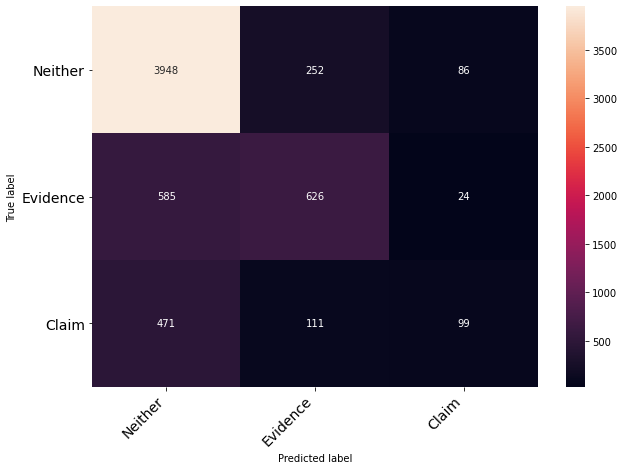

,Neither,Evidence,Claim
Neither,3948,252,86
Evidence,585,626,24
Claim,471,111,99


In [ ]:
#print confusion matrix
print_confusion_matrix(ds['label'].str[9:],
                           y_pred,
                           classb)

<h1>FastText Structure<h1>


* We load the structure dataset.

In [ ]:
data = load_corpus('dataset_aueb_structure_v2.json')
print(f'Dataset length: {len(data)} abstracts')

data.head(3)

Dataset length: 1014 abstracts


,document,sentences,labels
0,doi: 10.1001/jamaneurol.2017.2814,[Concordance Between Different Amyloid Immunoa...,"[NEITHER, BACKGROUND, BACKGROUND, BACKGROUND, ..."
1,doi: 10.1001/jamaneurol.2017.4913,[Association of Changes in Plasma Neurofilamen...,"[NEITHER, BACKGROUND, BACKGROUND, OBJECTIVE, M..."
2,doi: 10.1002/2015gl067056,[Dynamically triggered slip leading to sustain...,"[NEITHER, OBJECTIVE, METHOD, RESULT, RESULT, C..."


* We split our abstracts to sentences and labels per row.

In [ ]:
#@title Split to sentences
sentences = data['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences.sentence = sentences.sentence.astype("string")
sentences.sentence = sentences.sentence.str.strip()

In [ ]:
#@title and the corresponding labels
labels = data['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
labels

,doc_id,label
0,0,NEITHER
1,0,BACKGROUND
2,0,BACKGROUND
3,0,BACKGROUND
4,0,OBJECTIVE
...,...,...
10543,1013,METHOD
10544,1013,RESULT
10545,1013,RESULT
10546,1013,RESULT


* We split our dataset into train, test and validation and we use stratification.

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(sentences["sentence"],
                                                     labels['label'],
                                                     test_size=0.20,
                                                     random_state=42,
                                                     stratify=labels['label'])

 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
len(y_train), len(y_test), len(y_val)

(6328, 2110, 2110)

* Here, we can see the percentages of examples in each class for our training and test dataset with stratification.

In [ ]:
round(y_train.value_counts() / len(y_train) * 100, 2)

RESULT        26.00
BACKGROUND    20.07
OBJECTIVE     17.70
METHOD        15.08
CONCLUSION    11.38
NEITHER        9.78
Name: label, dtype: float64

In [ ]:
round(y_test.value_counts() / len(y_test) * 100, 2)

RESULT        25.64
BACKGROUND    20.19
OBJECTIVE     17.58
METHOD        15.21
CONCLUSION    11.75
NEITHER        9.62
Name: label, dtype: float64

In [ ]:
round(y_val.value_counts() / len(y_val) * 100, 2)

RESULT        24.60
BACKGROUND    20.52
OBJECTIVE     17.30
METHOD        15.50
CONCLUSION    12.99
NEITHER        9.10
Name: label, dtype: float64

* Create a dataframe with the train's X & y labels.

In [ ]:
#train dataset
df = pd.DataFrame(X_train)
df.columns = ['sentence']
df["label"] = y_train
df

,sentence,label
9100,"However, numerical investigations that focus o...",BACKGROUND
5394,We compared our estimates with those from the ...,METHOD
5174,Two large hexagonal pick-up coils with an equi...,METHOD
1855,Objective The purpose of this study was to inv...,OBJECTIVE
2941,"As a test bed, the anatase/rutile P25 is studi...",METHOD
...,...,...
5941,The availability of microbial genomes has open...,BACKGROUND
8278,Testing the vector competence of local mosquit...,BACKGROUND
1395,We achieve a very favorable balance between ac...,RESULT
10470,Summertime precipitation extremes in a EURO-CO...,NEITHER


* Create a dataframe with the test's X & y labels.

In [ ]:
#test dataset
ds = pd.DataFrame(X_test)
ds.columns = ['sentence']
ds["label"] = y_test
ds

,sentence,label
4060,Global emissions of carbon dioxide (CO 2 ) fro...,BACKGROUND
1494,Such differences are likely to have consequenc...,CONCLUSION
1128,Yet the number of unique lipids present is sur...,BACKGROUND
3938,Our study underscores the need to move beyond ...,CONCLUSION
354,"Moreover, a new compound based on PTM disubsti...",METHOD
...,...,...
6930,We compliment the authors on emphasising the i...,BACKGROUND
10290,The global aerosol–climate model ECHAM6.3–HAM2...,OBJECTIVE
8335,Results After correction for multiple comparis...,RESULT
8475,Mycobacterial pathogens are the causative agen...,BACKGROUND


* Create a dataframe with the validation's X & y labels.

In [ ]:
#valid dataset
dv = pd.DataFrame(X_val)
dv.columns = ['sentence']
dv["label"] = y_val
dv

,sentence,label
7246,We assessed systolic and diastolic LV function...,METHOD
8261,"Therefore, we conclude that bats in these urba...",CONCLUSION
5927,Recent developments in G protein-coupled recep...,BACKGROUND
8543,Personalized medicine does not rely on changes...,RESULT
9219,Vectors based on adeno-associated virus (AAV) ...,BACKGROUND
...,...,...
7145,Experiments in human cardiomyocytes face wide ...,BACKGROUND
5666,Rhythm control therapy improves symptoms and q...,RESULT
7966,"Using warfarin, simvastatin, voriconazole, ola...",CONCLUSION
3695,Genome-scale study reveals reduced metabolic a...,NEITHER


* We preprocess data and convert them into the format needed for the fasttext model to run.

In [ ]:
# NLP Preprocess
df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))
ds.iloc[:, 0] = ds.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))
dv.iloc[:, 0] = dv.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))

# Prefixing each row of the category column with 'label'
df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: '__label__' + x)
ds.iloc[:, 1] = ds.iloc[:, 1].apply(lambda x: '__label__' + x)
dv.iloc[:, 1] = dv.iloc[:, 1].apply(lambda x: '__label__' + x)

* We save the train,test and validation dataframes into a csv file in order to train the classifier.

In [ ]:
# Saving the CSV file as a text file to train/test the classifier
df[['label', 'sentence']].to_csv('train_str.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")

ds[['label', 'sentence']].to_csv('test_str.txt', 
                                     index = False, 
                                     sep = ' ',
                                     header = None, 
                                     quoting = csv.QUOTE_NONE, 
                                     quotechar = "", 
                                     escapechar = " ")
dv[['label', 'sentence']].to_csv('validation_str.txt', 
                                     index = False, 
                                     sep = ' ',
                                     header = None, 
                                     quoting = csv.QUOTE_NONE, 
                                     quotechar = "", 
                                     escapechar = " ")

* We train the model using the train dataset and we evaluate the model on the test dataset.

In [ ]:
model_str = fasttext.train_supervised('train_str.txt', lr=0.1, epoch=7, wordNgrams=1)

# Evaluating performance on the entire test file
pred = model_str.test('test_str.txt')                      

* As we can see, the precision and recall for the model is nearly 58 percent.

In [ ]:
pred

(2110, 0.5772511848341232, 0.5772511848341232)

* As we can see accuracy is also nearly 58 percent.

In [ ]:
|predicted=[]
for i in range(len(ds)):
    a = model_str.predict(ds.iloc[i][0])[0][0]
    predicted.append(a)  

In [ ]:
actual = ds.label.tolist()

In [ ]:
num_correct = 0
for i in range(len(predicted)):
    if predicted[i] == actual[i]:
        num_correct += 1

In [ ]:
accuracy = num_correct/len(predicted)
accuracy

0.5772511848341232

* Last but not least, we create and show the confusion matrix.

In [ ]:
y_pred = []
for i in range(len(X_test)):
  item = X_test.iloc[i]
  item = item.replace("\n"," ")
  z = model_str.predict(item)[0][0][9:]
  y_pred.append(z)

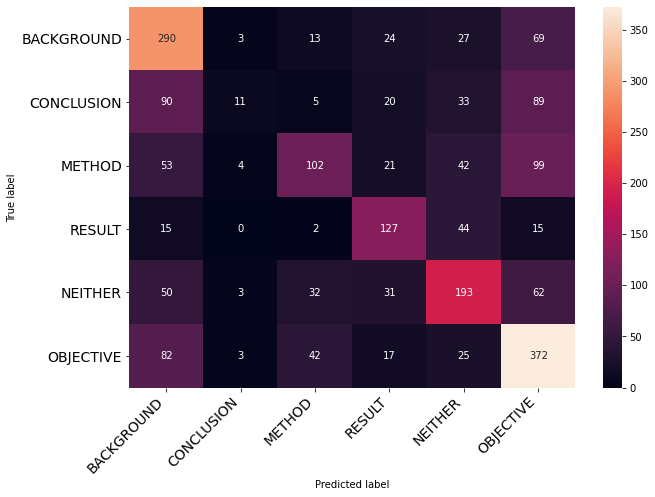

,BACKGROUND,CONCLUSION,METHOD,RESULT,NEITHER,OBJECTIVE
BACKGROUND,290,3,13,24,27,69
CONCLUSION,90,11,5,20,33,89
METHOD,53,4,102,21,42,99
RESULT,15,0,2,127,44,15
NEITHER,50,3,32,31,193,62
OBJECTIVE,82,3,42,17,25,372


In [ ]:
class_names = y_test.unique()
#print confusion matrix
print_confusion_matrix(y_test,
                           y_pred,
                           class_names)